# American Sign Language Image Recognition | Group 31

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import pathlib

### Load Dataset

In [2]:
training_data_dir = pathlib.Path("images/asl_alphabet_train")
testing_data_dir = pathlib.Path("images/asl_alphabet_test")

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  training_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(200, 200),
  batch_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
  training_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(200, 200),
  batch_size=32)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


### get the class names

In [4]:
## class_names correspond to the directory names in alphabetical order
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


In [6]:
# use buffered prefetching, so you can yield data from disk without having I/O become blocking
# dataset.cashe keeps images in memeory after theyre loaded off disk during first epoch
# dataset.prefetch overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# normalized the RGB channel from [0,255] to [0,1]
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [8]:
# we then have 3 convoulition bloicks and a max pooling layer in each of them
# using ReLU as the activation function
num_classes = len(class_names)

### train the model for the first time

In [9]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(200, 200, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# view the training and validation accuracy foor each training epoch by using model.compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [10]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

model.summary()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10


2175/2175 [==============================] - 1049s 476ms/step - loss: 0.7689 - accuracy: 0.7613 - val_loss: 0.1449 - val_accuracy: 0.9534
Epoch 2/10
2175/2175 [==============================] - 1059s 487ms/step - loss: 0.1025 - accuracy: 0.9659 - val_loss: 0.1006 - val_accuracy: 0.9672
Epoch 3/10
2175/2175 [==============================] - 1056s 485ms/step - loss: 0.0575 - accuracy: 0.9809 - val_loss: 0.0862 - val_accuracy: 0.9706
Epoch 4/10
2175/2175 [==============================] - 1049s 483ms/step - loss: 0.0427 - accuracy: 0.9862 - val_loss: 0.0930 - val_accuracy: 0.9732
Epoch 5/10
2175/2175 [==============================] - 1063s 489ms/step - loss: 0.0358 - accuracy: 0.9884 - val_loss: 0.0309 - val_accuracy: 0.9897
Epoch 6/10
2175/2175 [==============================] - 1060s 487ms/step - loss: 0.0279 - accuracy: 0.9908 - val_loss: 0.0614 - val_accuracy: 0.9801
Epoch 7/10
2175/2175 [==============================] - 1065s 489ms/step - loss: 0.0257 - accuracy: 0.9923 - val_loss

### plot the model's training and test results

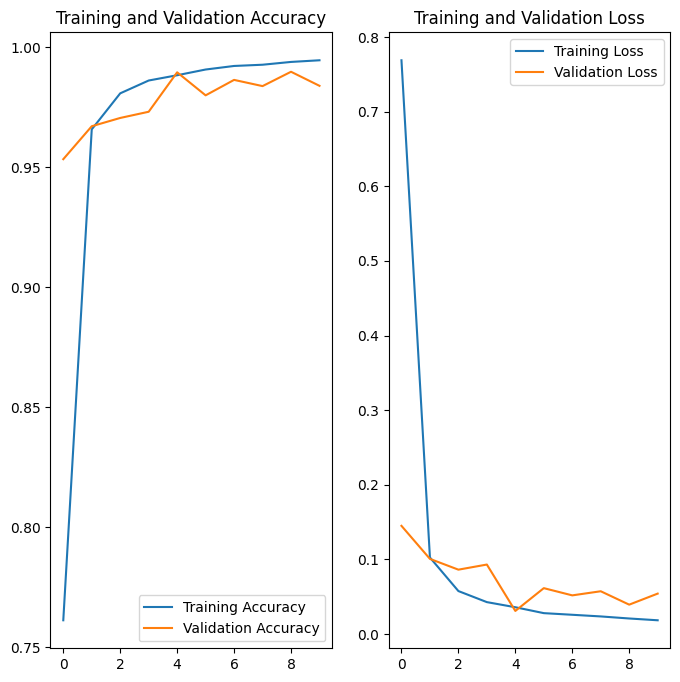

In [11]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### augment the images to inprove model's accuracy

In [14]:
# augment the data using random transformations to yield believable looking images to expose the model
# to more aspects of the data and generalize better
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(200, 200, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# used dropout to reduce overfitting 
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                 

In [15]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/15
2175/2175 [==============================] - 1157s 531ms/step - loss: 1.7492 - accuracy: 0.4545 - val_loss: 0.7637 - val_accuracy: 0.7363
Epoch 2/15
2175/2175 [==============================] - 1144s 526ms/step - loss: 0.7449 - accuracy: 0.7488 - val_loss: 0.4729 - val_accuracy: 0.8367
Epoch 3/15
2175/2175 [==============================] - 1148s 528ms/step - loss: 0.5025 - accuracy: 0.8289 - val_loss: 0.4519 - val_accuracy: 0.8393
Epoch 4/15
2175/2175 [==============================] - 1140s 524ms/step - loss: 0.3833 - accuracy: 0.8667 - val_loss: 0.1909 - val_accuracy: 0.9338
Epoch 5/15
2175/2175 [==============================] - 1141s 524ms/step - loss: 0.3126 - accuracy: 0.8926 - val_loss: 0.2470 - val_accuracy: 0.9163
Epoch 6/15
2175/2175 [==============================] - 1138s 523ms/step - loss: 0.2737 - accuracy: 0.9073 - val_loss: 0.1676 - val_accuracy: 0.9427
Epoch 7/15
2175/2175 [==============================] - 1142s 525ms/step - loss: 0.2449 - accuracy: 0.9162

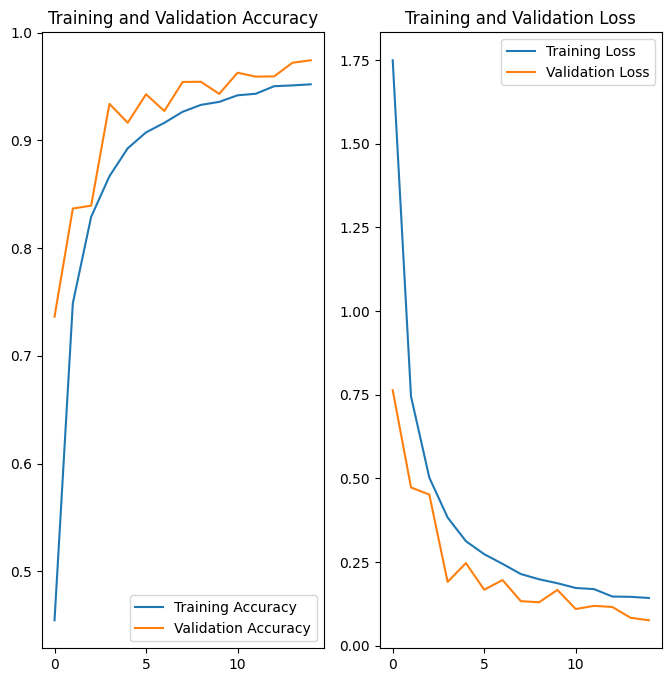

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### save the model to a file to call upon on the front-end

In [17]:
tf.keras.models.save_model(model,'my_model.hdf5')

C:\Users\ALEX\AppData\Local\Temp\ipykernel_16248\1701436818.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'my_model.hdf5')
